In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [2]:
# Importing Necessary Libraries
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
import numpy as np
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Checking if the Backend Supports OpenPulse
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

In [4]:
# Checking the Properties of the Backend
backend_defaults = backend.defaults()

In [5]:
# Computing the Sampling Time
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [6]:
# Finding the Qubit Frequency
GHz = 1.0e9
MHz = 1.0e6
qubit = 0
# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]                                                         
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")
# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974274140201491 GHz.
The sweep will go from 4.95427414020149 GHz to 4.99427414020149 GHz in steps of 1.0 MHz.


In [7]:
def get_closest_multiple_of_16(num):
    return (int(num) - (int(num)%16))

In [8]:
# Importing Pulse Dependancies
from qiskit import pulse            
from qiskit.pulse import pulse_lib 
# Drive pulse parameters (SETTING THE PULSE LENGTH)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * 1e-6/dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * 1e-6/dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [9]:
### Construct the measurement pulse
# Measurement pulse parameters

meas_samples_us = 3.0
meas_sigma_us = 0.014     # The width of the gaussian part of the rise and fall
meas_risefall_us = 0.1    # and the truncating parameter: how many samples to dedicate to the risefall

meas_samples = get_closest_multiple_of_16(meas_samples_us * 1e-6/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * 1e-6/dt)         # The width of the gaussian part of the rise and fall
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * 1e-6/dt)     # and the truncating parameter: how many samples to dedicate to the risefall

# meas_samples = 12800
# meas_sigma = 64         # The width of the gaussian part of the rise and fall
# meas_risefall = 400     # and the truncating parameter: how many samples to dedicate to the risefall

meas_amp = 0.25
# Measurement pulse samples
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples,
                                       sigma=meas_sigma,
                                       amp=meas_amp,
                                       risefall=meas_risefall,
                                       name='measurement_pulse')

### Construct the acquire pulse to trigger the acquisition
# Acquire pulse samples
acq_cmd = pulse.Acquire(duration=meas_samples)

In [10]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [11]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [12]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)

# In a new schedule, which we will use again later, add a measurement stimulus on the
# measure channel pulse to trigger readout
measure_schedule = meas_pulse(meas_chan)
# Trigger data acquisition, and store measured values into respective memory slots
measure_schedule += acq_cmd([pulse.AcquireChannel(i) for i in backend_config.meas_map[meas_map_idx]],
                            [pulse.MemorySlot(i) for i in backend_config.meas_map[meas_map_idx]])
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure_schedule << schedule.duration

# Create the frequency settings for the sweep
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [14]:
job = backend.run(frequency_sweep_program)

In [15]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [16]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 60 seconds

In [17]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

In [18]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [19]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 sweep_values, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-2e10, 4.975, 1, 3e10] # initial parameters for curve_fit
                                )

In [20]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = round(rough_qubit_frequency, 5)
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {rough_qubit_frequency} GHz.")

We've updated our qubit frequency estimate from 4.97427 GHz to 4.97436 GHz.


# ROUGH CALIBRATION PHASE

In [21]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure_schedule`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 64 amplitudes evenly spaced from 0 to 0.1
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [22]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += rabi_pulse(drive_chan)
    # Reuse the measure_schedule from the frequency sweep experiment
    this_schedule += measure_schedule << this_schedule.duration
    rabi_schedules.append(this_schedule)

In [23]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [24]:
job = backend.run(rabi_experiment_program)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [25]:
rabi_results = job.result(timeout=120)

In [26]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [27]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit])

rabi_values = baseline_remove(rabi_values)    

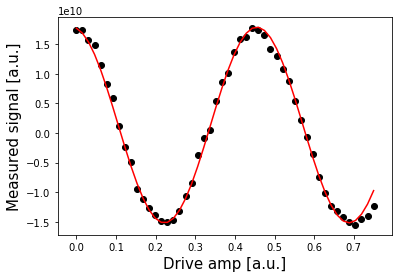

In [28]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1.5e10, 0.1e10, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [29]:
_,_,drive_period,_ = fit_params
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.23294397888961965


In [30]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

# FINE CALIBRATION PHASE

In [83]:
# pi/2 calibration points
pulse_numbers = [0,1,2,3,5,7,9,11,13]
drive_amp = (pi_amp/2) #0.92799 
pio2_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")

In [84]:
# Building the Rabi Experiments
schedules = []
for i in [0,1,2,3,5,7,9,11,13]:
    pingpong_schedule = pulse.Schedule()
    for j in range(i):
        pingpong_schedule += pio2_pulse(drive_chan)
    pingpong_schedule += measure_schedule << pingpong_schedule.duration
    schedules.append(pingpong_schedule)

In [85]:
# Assembling the Schedules into a Quantum Object
num_shots_per_point = 4096

pingpong_experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                *9)

In [86]:
# Sending the Job to QC
job = backend.run(pingpong_experiment_program)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [87]:
pingpong_results = job.result(timeout=120)

In [88]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

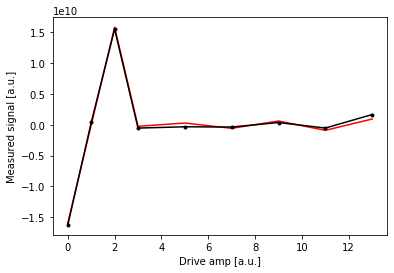

[-1.59014620e+10 -5.67568585e+07  3.98701677e+00 -3.64136953e-03]
[-1.59581135e+10 -3.33222996e+07  1.58443600e+10 -2.42862510e+08
  2.92000409e+08 -5.68129242e+08  6.17177123e+08 -8.93181906e+08
  9.42071718e+08]
-15901462022.754883


In [89]:
import scipy as sc

pingpong_values = []
for i in range(9):
    # Get the results for `qubit` from the ith experiment
    pingpong_values.append(pingpong_results.get_memory(i)[qubit])

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")

pingpong_values = baseline_remove(pingpong_values)    
# Plotting the Ideal Cosine Curve


fit_params, y_fit = fit_function([2*np.pi*i for i in pulse_numbers],
                                pingpong_values, 
                                lambda x, A, B, drive_period, phi: A*(np.cos(x/drive_period + phi))+B,
                                [1.5e10, 0, 4, 0])

plt.plot(pulse_numbers, y_fit, color='red')
plt.plot([0,1,2,3,5,7,9,11,13], pingpong_values, color='black',linestyle='-',marker='.')
plt.show()
print(fit_params)
print(y_fit)
print(fit_params[0])
#(A*np.cos(2*np.pi*x/drive_period - phi) + B)

### 

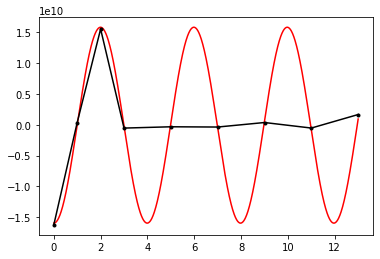

In [101]:
A = fit_params[0]
B = fit_params[1]
drive_period = fit_params[2]
phi = fit_params[3]

theta = np.linspace(0,13,1000)
y = [A*(np.cos(2*np.pi*x/drive_period + phi))+B for x in theta]

plt.plot(theta, y, color='red')
plt.plot([0,1,2,3,5,7,9,11,13], pingpong_values, color='black',linestyle='-',marker='.')


Job Status: job has successfully run


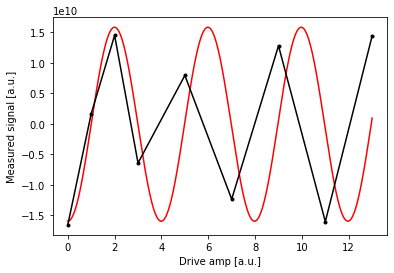

3.987016767379368
Job Status: job has successfully run


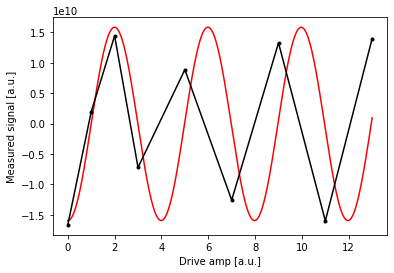

3.987016767379368
Job Status: job is being validated

KeyboardInterrupt: 

In [108]:


drive_amp = pi_amp/2
while abs(2/drive_period - 0.5) > 0.0001:
    pio2_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    
    schedules = []
    for i in [0,1,2,3,5,7,9,11,13]:
        pingpong_schedule = pulse.Schedule()
        for j in range(i):
            pingpong_schedule += pio2_pulse(drive_chan)
        pingpong_schedule += measure_schedule << pingpong_schedule.duration
        schedules.append(pingpong_schedule)
    
    pingpong_experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                *9)
    
    job = backend.run(pingpong_experiment_program)
    job_monitor(job)
    pingpong_results = job.result(timeout=120)
    def baseline_remove(values):
        return np.array(values) - np.mean(values)
    pingpong_values = []
    for i in range(9):
        pingpong_values.append(pingpong_results.get_memory(i)[qubit])

    plt.xlabel("Drive amp [a.u.]")
    plt.ylabel("Measured signal [a.u.]")

    pingpong_values = baseline_remove(pingpong_values)    

    A = fit_params[0]
    B = fit_params[1]
    drive_period = fit_params[2]
    phi = fit_params[3]

    theta = np.linspace(0,13,1000)
    y = [A*(np.cos(2*np.pi*x/drive_period + phi))+B for x in theta]

    plt.plot(theta, y, color='red')
    plt.plot([0,1,2,3,5,7,9,11,13], pingpong_values, color='black',linestyle='-',marker='.')
    plt.show()
    
    print(drive_period)
    drive_amp = drive_amp*(4/drive_period)